In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import sys

from scipy.stats import gamma, beta
# import talib
from tqdm.notebook import tqdm
from functools import partial
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

c:\Users\Lukas.Schumacher\miniconda3\envs\cogModeling\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
sys.path.append("../../src")
from networks_10092022 import DynamicGaussianNetworkJoint
from priors import diffusion_prior, random_walk_prior
from micro_models import simple_batch_diffusion, diffusion_trial
from macro_models import random_walk_shared_var, random_walk
from context import generate_design_matrix
from transformations import scale_z, unscale_z

In [3]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [4]:
N_SIM = 100
N_OBS = 100
N_SAMPLES = 4000
N_PARAMS = 3

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [5]:
MACRO_MEAN  = beta(a=1, b=25).mean()
MACRO_STD   = beta(a=1, b=25).std()
MICRO_MEANS = [1.75, 1.7, 1] # calculated based on 10000 simulated theta_1:3200
MICRO_STDS   = [1.5, 1.25, 1] # calculated based on 10000 simulated theta_1:3200

In [6]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [7]:
# load simulated data and ture params
sim = pd.read_pickle('../../data/sim_data/static_dm_data_100.pkl')
x_nn = sim['rt']
micro_true = sim['theta']
x_nn.shape

(100, 100, 1)

## Prepare dynamic stan posteriors

In [8]:
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [9]:
mypath = "C:/Users/Lukas.Schumacher/Documents/GitHub/dynamic_dm/benchmarks/stan/dynamic_stan_fits"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files.sort(key=natural_keys)
len(files)


100

In [10]:
dynamic_stan_post = np.empty((N_SIM, N_OBS, N_SAMPLES, N_PARAMS))
for i in range(len(files)):
    post_samples = pd.read_csv('dynamic_stan_fits/' + files[i], index_col=False)
    dynamic_stan_post[i] = post_samples.to_numpy()[:, 3:].reshape(100, 4000, 3)

dynamic_stan_post.shape

(100, 100, 4000, 3)

In [11]:
# get mean and std of posterior stds
dynamic_stan_post_std_means = dynamic_stan_post.std(axis=2).mean(axis=0)
dynamic_stan_post_std_stds = dynamic_stan_post.std(axis=2).std(axis=0)

In [12]:
# get posterior means
dynamic_stan_post_means = dynamic_stan_post.mean(axis=2)
dynamic_stan_post_means.shape


(100, 100, 3)

In [13]:
dynamic_stan_abs_error = np.empty((N_SIM, N_OBS, N_PARAMS))
for i in range(N_SIM):
    dynamic_stan_abs_error[i] = np.abs(dynamic_stan_post_means[i] - micro_true[i])
dynamic_stan_abs_error.shape

(100, 100, 3)

In [14]:
dynamic_stan_abs_error_mean = dynamic_stan_abs_error.mean(axis=0)
dynamic_stan_abs_error_std = dynamic_stan_abs_error.std(axis=0)

## Neural Training

In [15]:
def generator_fun(batch_size, T, scale_micro_by_max=8., scale_macro=True):
    theta = diffusion_prior(batch_size, n_cond=1)
    eta = random_walk_prior(batch_size, 3)
    theta_t = random_walk(theta, eta, T)
    rt = simple_batch_diffusion(theta_t).astype(np.float32)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEANS,  MICRO_STDS)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), rt

In [16]:
eta_z, theta_t_z, rt = generator_fun(32, N_OBS)
theta_t_z.shape

(32, 100, 3)

In [17]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [18]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            macro_params, micro_params, data = generator() 

            # Forward pass
            posterior = network(data)

            # loss computation
            T = int(micro_params.shape[1])
            loss = nll(tf.concat([tf.stack([macro_params] * T, axis=1), micro_params], axis=-1), posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [19]:
network_settings = {
    'embedding_lstm_units' : 512, # increase from 128 to 256
    'embedding_gru_units': 512, # increase from 128 to 256
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 3,
    'n_macro_params': 3
}
network = DynamicGaussianNetworkJoint(network_settings)

In [20]:
T = 100
batch_size = 32
simulator = partial(generator_fun, T=T, batch_size=batch_size)
epochs = 100
steps_per_epoch = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [21]:
# losses = []
# for ep in range(1, epochs+1):
#     with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(losses_ep)

In [22]:
# network.save_weights('trained_networks/1_drift_100_joint_21Sept')

## Fit dynamic dm to static data

In [23]:
network.load_weights("../../trained_networks/1_drift_100_joint_21Sept")

In [24]:
# fit model
post_eta_z, post_theta_t_z = network.sample_n(x_nn, N_SAMPLES)
post_theta_t_z.shape

TensorShape([4000, 100, 100, 3])

In [25]:
post_eta = unscale_z(post_eta_z, MACRO_MEAN, MACRO_STD).numpy()
post_theta_t = unscale_z(post_theta_t_z, MICRO_MEANS, MICRO_STDS).numpy()

In [26]:
# get mean and sd posterior sd's from dynamic model fits
neural_post_std_means = post_theta_t.std(axis=0).mean(axis=0)
neural_post_std_stds = post_theta_t.std(axis=0).std(axis=0)

In [27]:
neural_post_means = post_theta_t.mean(axis=0)
neural_post_means.shape

(100, 100, 3)

In [28]:
neural_abs_error = np.empty((N_SIM, N_OBS, N_PARAMS))
for i in range(N_SIM):
    neural_abs_error[i] = np.abs(neural_post_means[i] - micro_true[i])

neural_abs_error_mean = np.mean(neural_abs_error, axis=0)
neural_stan_abs_error_std = np.std(neural_abs_error, axis=0)

## Plotting

In [29]:
np.save("saved_arrays/neural_abs_error_mean_joint.npy", neural_abs_error_mean)
np.save("saved_arrays/neural_stan_abs_error_std_joint.npy", neural_stan_abs_error_std)

np.save("saved_arrays/dynamic_stan_abs_error_mean_joint.npy", dynamic_stan_abs_error_mean)
np.save("saved_arrays/dynamic_stan_abs_error_std_joint.npy", dynamic_stan_abs_error_std)

np.save("saved_arrays/neural_post_std_means_joint.npy", neural_post_std_means)
np.save("saved_arrays/neural_post_std_stds_joint.npy", neural_post_std_stds)

np.save("saved_arrays/dynamic_stan_post_std_means_joint.npy", dynamic_stan_post_std_means)
np.save("saved_arrays/dynamic_stan_post_std_stds_joint.npy", dynamic_stan_post_std_stds)

In [30]:
# neural_abs_error_mean = np.load("saved_arrays/neural_abs_error_mean_joint.npy")
# neural_stan_abs_error_std = np.load("saved_arrays/neural_stan_abs_error_std_joint.npy")

# dynamic_stan_abs_error_mean = np.load("saved_arrays/dynamic_stan_abs_error_mean_joint.npy")
# dynamic_stan_abs_error_std = np.load("saved_arrays/dynamic_stan_abs_error_std_joint.npy")

# neural_post_std_means = np.load("saved_arrays/neural_post_std_means_joint.npy")
# neural_post_std_stds = np.load("saved_arrays/neural_post_std_stds_joint.npy")

# dynamic_stan_post_std_means = np.load("saved_arrays/dynamic_stan_post_std_means_joint.npy")
# dynamic_stan_post_std_stds = np.load("saved_arrays/dynamic_stan_post_std_stds_joint.npy")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


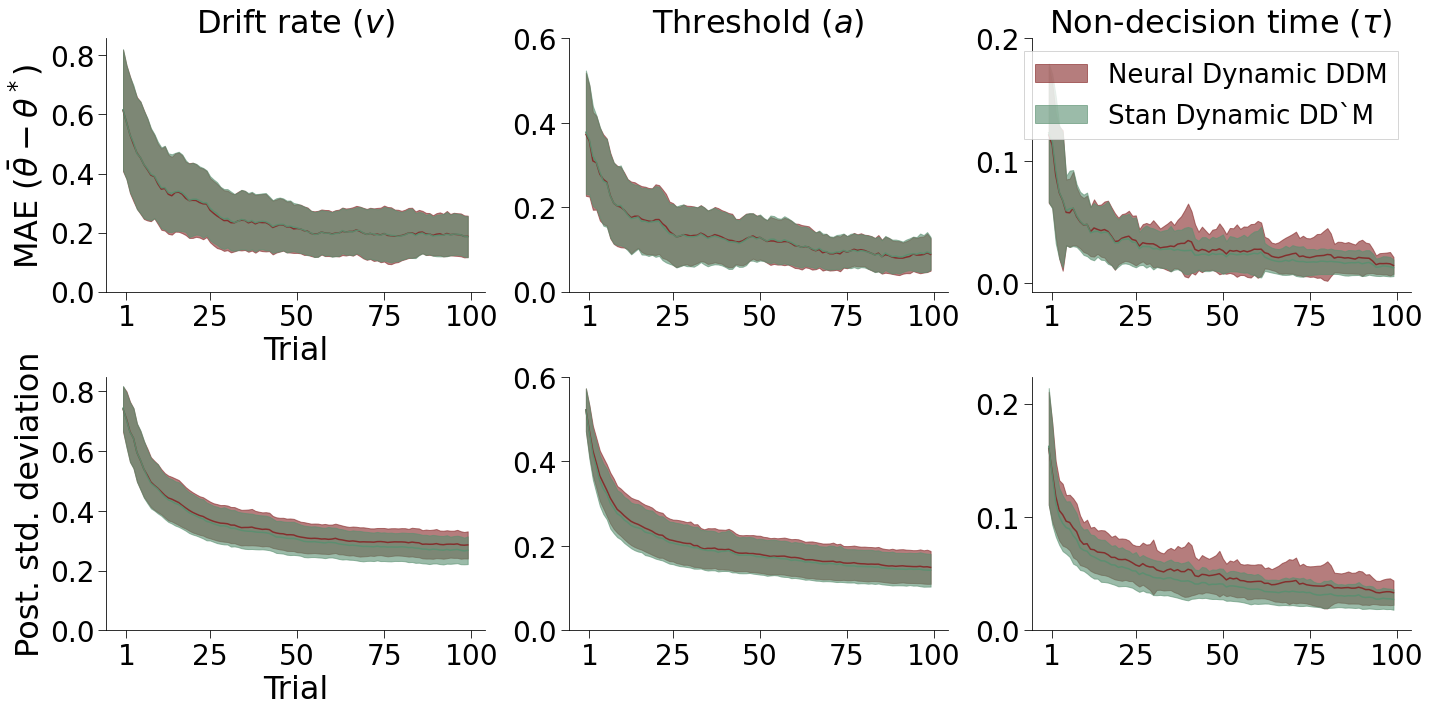

In [31]:
param_labels = ['Drift rate', 'Threshold', 'Non-decision time']
param_names = [r'$v$', r'$a$', r'$\tau$']
font_size_large = 32
font_size_small = 26
time = np.arange(dynamic_stan_post_std_stds.shape[0])
ALPHA = 0.6
f, axarr = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axarr.flat):
    if i < 3:
        # plot neural results
        ax.plot(time, neural_abs_error_mean[:, i], alpha=0.9, color='#852626')
        ax.fill_between(time, neural_abs_error_mean[:, i] - neural_stan_abs_error_std[:, i]/2, neural_abs_error_mean[:, i] + neural_stan_abs_error_std[:, i]/2,
                        alpha=ALPHA, label='Neural Dynamic DDM', color='#852626')

        # plot dynamic stan
        ax.plot(time, dynamic_stan_abs_error_mean[:, i], alpha=0.9, color='#598f70')
        ax.fill_between(time, dynamic_stan_abs_error_mean[:, i] - dynamic_stan_abs_error_std[:, i]/2, dynamic_stan_abs_error_mean[:, i] + dynamic_stan_abs_error_std[:, i]/2,
                        alpha=ALPHA, label='Stan Dynamic DDM', color='#598f70')

        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=font_size_large)

        if i == 0:
            ax.set_xlabel('Trial', fontsize=font_size_large)
            ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=font_size_large)
        if i == 2:
            ax.legend(fontsize=font_size_small, loc='best', fancybox=False, shadow=False)

    else:
        # plot neural results
        ax.plot(time, neural_post_std_means[:, i-3], alpha=0.9, color='#852626')
        ax.fill_between(time, neural_post_std_means[:, i-3]+neural_post_std_stds[:, i-3]/2, neural_post_std_means[:, i-3]-neural_post_std_stds[:, i-3]/2,
                        alpha=ALPHA, label='Neural Dynamic DM', color='#852626')

        # plot dynamic stan
        ax.plot(time, dynamic_stan_post_std_means[:, i-3], alpha=0.9, color='#598f70')
        ax.fill_between(time, dynamic_stan_post_std_means[:, i-3]+dynamic_stan_post_std_stds[:, i-3]/2, dynamic_stan_post_std_means[:, i-3]-dynamic_stan_post_std_stds[:, i-3]/2,
                        alpha=ALPHA, label='Stan Dynamic DM', color='#598f70')
        
        
        if i == 3:
            ax.set_xlabel('Trial', fontsize=font_size_large)
            ax.set_ylabel('Post. std. deviation', fontsize=font_size_large)

    if i == 0 or i == 3:
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    elif i == 1 or i == 4:
        ax.set_yticks([0.0, 0.2, 0.4, 0.6])
    else:
        ax.set_yticks([0.0, 0.1, 0.2])

    ax.set_xticks([1, 25, 50, 75, 100])
    ax.tick_params(axis='both', which='major', labelsize=28, length=8)
    # ax.grid(alpha=0.3)

sns.despine()
plt.tight_layout()
plt.savefig('../../plots/plot_stan_benchmark_joint.png', dpi=300)